In [1]:
import gpflow
import tensorflow as tf
tf.config.run_functions_eagerly(True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

import warnings
import os
import operator
import sys
sys.path.insert(1, '../')

from hgpmoe.data import load_feature
from hgpmoe.metrics import compute_metrics_gpr, compute_metrics_hgpmoe
from hgpmoe.hgp import HierarchicalGP
from hgpmoe.moe import ExpertsMixGP
from hgpmoe.plot import pred_x

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline

MAXITER = ci_niter(2000)

# Example of fitting GPR, HGP and MOE on Penn COVID-19 patient trajectories

The **goal** of this notebook is to present a vignette of the albumin covariate discussed in the main text of our paper. It is an example in which patients in a cohort follow a naturally occurring **group structure**, and whose trajectories are better fit with HGP/MOE than with GPR.

## Load data for our feature (albumin)

In [26]:
feature = 'ALBUMIN'
X, Y, X_test, Y_test, cluster_assignments = load_feature(feature)

### Take a look at the trajectories

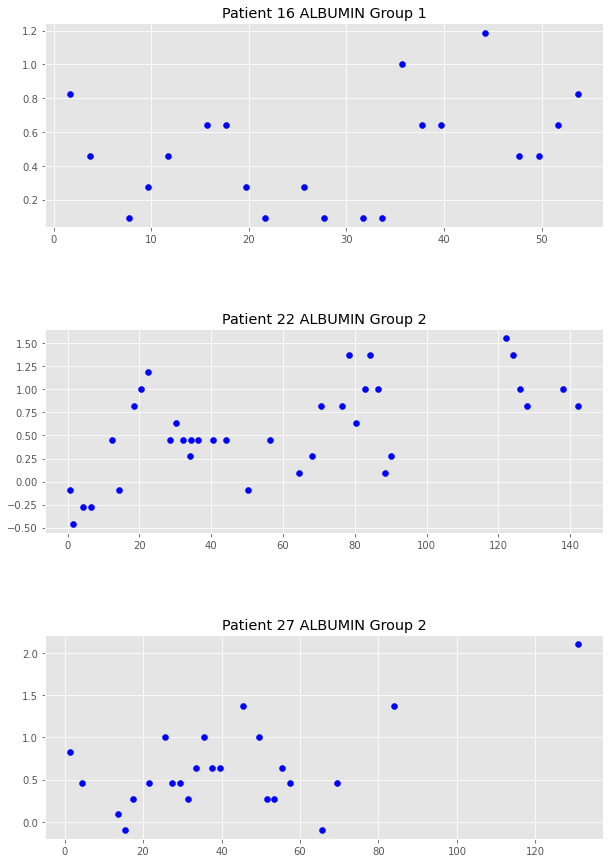

In [3]:
import matplotlib.pyplot as plt

n_examples = 3
fig, axs = plt.subplots(n_examples, 1, figsize=(10, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

indices = np.random.choice(len(cluster_assignments), n_examples, replace=False)
indices = sorted(indices)
axs_idx = 0
for i in indices:
    axs[axs_idx].set_title('Patient %d ' %i + feature + " Group %d" %cluster_assignments[i])
    axs[axs_idx].scatter(X[i], Y[i], color='blue')
    axs_idx += 1
    

# Models

## GPR

Fit one GPR Model to each patient

In [14]:
gpr_models = []

for i in range(len(X)):
    k = gpflow.kernels.Matern52()
    m = gpflow.models.GPR(data=(X[i].reshape(-1, 1), Y[i].reshape(-1, 1)), kernel=k, mean_function=None)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=10000))
    gpr_models.append(m)

In [15]:
# Check out parameters for one such model
print_summary(gpr_models[0])

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.409326
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,11.0136
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0828734


In [16]:
# Compute metrics
gpr_train_mse, gpr_test_mse, gpr_train_r2, gpr_test_r2, gpr_ci = compute_metrics_gpr(gpr_models,
                                                                            X, Y, X_test, Y_test)

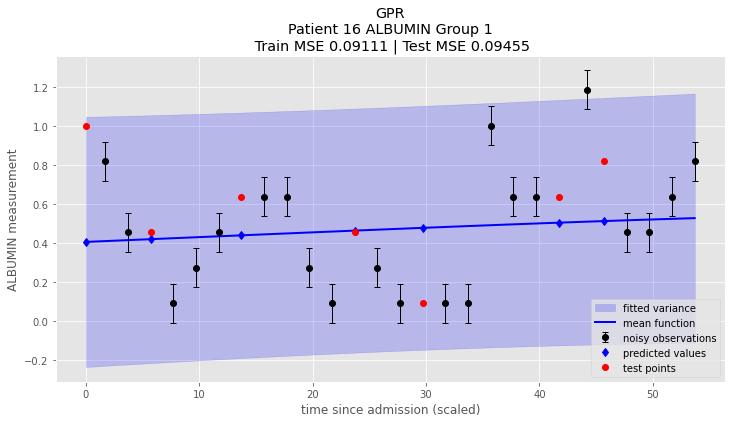

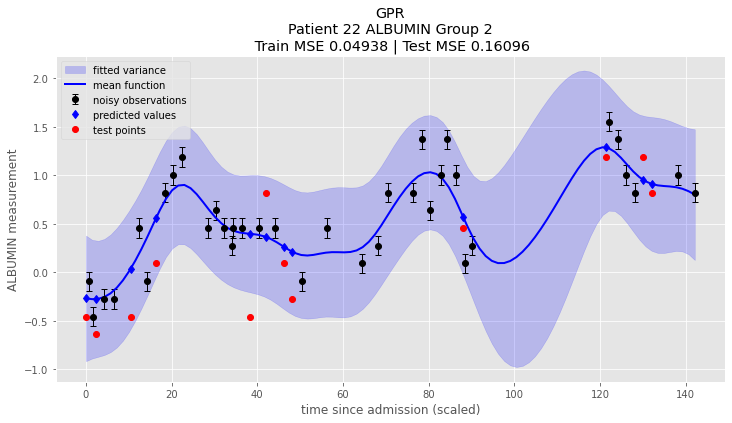

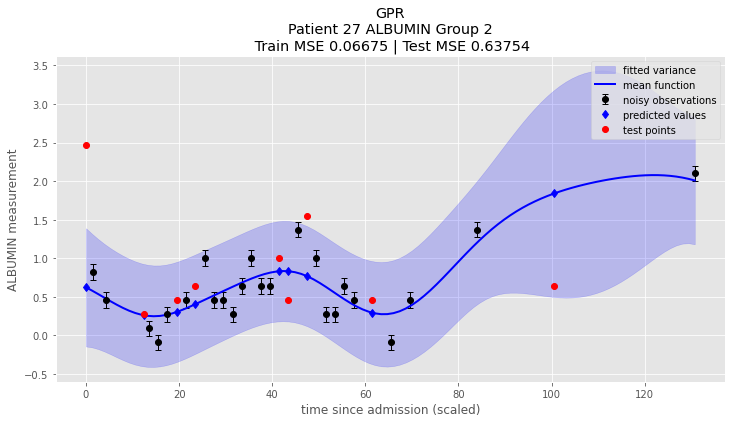

In [7]:
# Plot examples
for patient_idx in indices:
    pred_x(gpr_models[patient_idx], patient_idx, 
           X, Y,
           cluster_assignments,
           X_test=X_test, Y_test=Y_test, model_name='GPR',
           feature=feature, n_test_points=10)

# HGP

In [27]:
hgp = HierarchicalGP((X, Y), cluster_assignments, taper=True)
print_summary(hgp)

Patient  1  minimizes cluster  0
Patient  11  minimizes cluster  1
Patient  23  minimizes cluster  2
Patient  38  minimizes cluster  3


name,class,transform,prior,trainable,shape,dtype,value
HierarchicalGP.Wasserstein.variance,Parameter,Softplus,,False,(),float64,1
HierarchicalGP.Wasserstein.lengthscales,Parameter,Softplus,,False,(),float64,1
HierarchicalGP.K_group_list[0].variance,Parameter,Softplus,,True,(),float64,1
HierarchicalGP.K_group_list[0].lengthscales,Parameter,Softplus,,True,(),float64,1
HierarchicalGP.K_group_list[1].variance,Parameter,Softplus,,True,(),float64,1
HierarchicalGP.K_group_list[1].lengthscales,Parameter,Softplus,,True,(),float64,1
HierarchicalGP.K_group_list[2].variance,Parameter,Softplus,,True,(),float64,1
HierarchicalGP.K_group_list[2].lengthscales,Parameter,Softplus,,True,(),float64,1
HierarchicalGP.K_group_list[3].variance,Parameter,Softplus,,True,(),float64,1
HierarchicalGP.K_group_list[3].lengthscales,Parameter,Softplus,,True,(),float64,1


In [28]:
opt = gpflow.optimizers.Scipy()
opt.minimize(hgp.training_loss, hgp.trainable_variables, options=dict(maxiter=1000))

      fun: 736.2457062607231
 hess_inv: <91x91 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.20115275e-03, -1.77885076e-04, -2.97230938e-04, -6.12278571e-03,
       -6.75192672e-04,  2.58203656e-02,  2.27559249e-03,  4.36678613e-03,
       -4.67758690e-09, -2.86369078e-02, -7.46911159e-04,  2.41582996e-03,
        3.27967901e-04,  1.97220386e-03,  3.02883889e-03,  1.35997798e-03,
        3.77995438e-03,  1.27545365e-03, -8.06803124e-03, -6.54249638e-03,
        8.17809980e-22, -9.47258269e-03, -3.86905778e-03, -2.13618590e-03,
       -9.66008596e-04, -4.45167818e-04,  6.73358533e-03, -2.79209018e-02,
        1.06591307e-33, -2.41200498e-04, -1.52773852e-03, -6.90879501e-04,
        1.88030824e-03,  3.15935355e-03,  1.58292575e-04,  9.17774183e-05,
        2.06626739e-02, -4.10796295e-02,  9.48626926e-04, -1.20409269e-04,
       -9.77681250e-03, -2.45756435e-03, -4.33759154e-04, -2.06875099e-04,
       -4.85638791e-03, -2.37795440e-03, -1.54547687e-05,  7.12876819e-05,
  

In [29]:
hgp_train_mse, hgp_test_mse, hgp_train_r2, hgp_test_r2, hgp_ci = compute_metrics_hgpmoe(hgp,
                                                                            X, Y, X_test, Y_test)

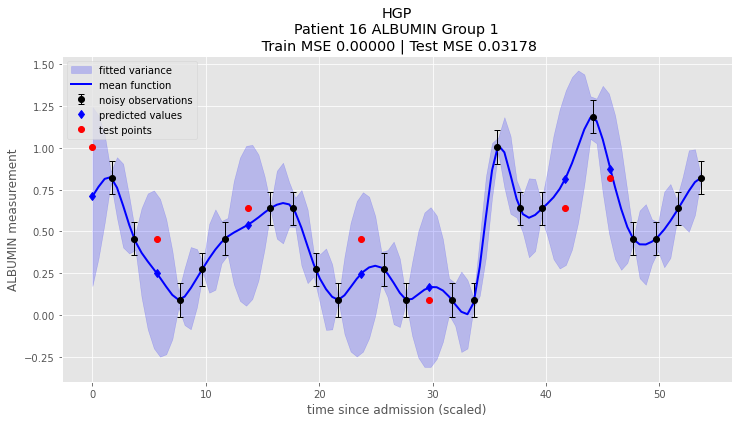

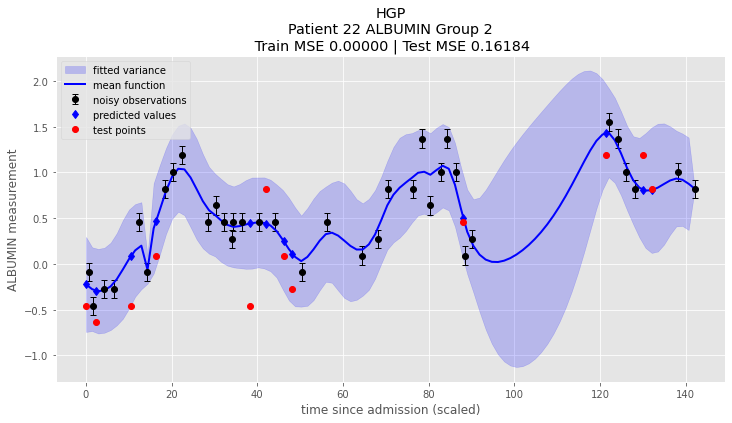

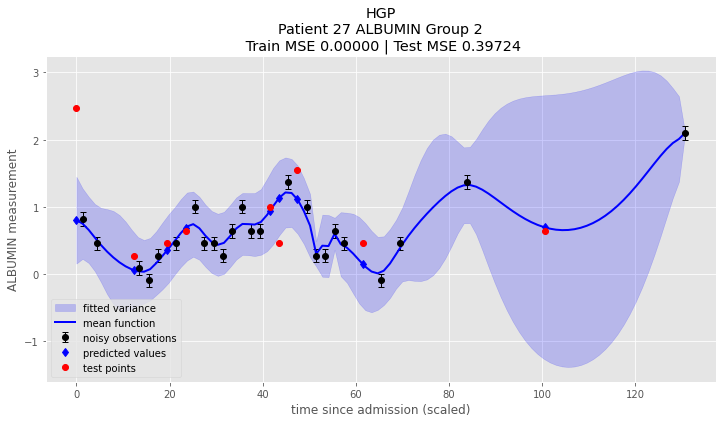

In [30]:
# Plot examples
for patient_idx in indices:
    pred_x(hgp, patient_idx, 
           X, Y,
           cluster_assignments,
           X_test=X_test, Y_test=Y_test, model_name='HGP',
           feature=feature, n_test_points=10)

# MOE

In [33]:
# Reload for MOE
X, Y, X_test, Y_test, cluster_assignments = load_feature(feature, model_type='moe')
moe = ExpertsMixGP((X, Y), cluster_assignments, taper=True)
print_summary(moe)

Patient  11  minimizes cluster with attribute 0
Patient  23  minimizes cluster with attribute 1
Patient  38  minimizes cluster with attribute 2
Patient  23  minimizes cluster with attribute 3


name,class,transform,prior,trainable,shape,dtype,value
ExpertsMixGP.Wasserstein.variance,Parameter,Softplus,,False,(),float64,1
ExpertsMixGP.Wasserstein.lengthscales,Parameter,Softplus,,False,(),float64,1
ExpertsMixGP.K_group['0'].variance,Parameter,Softplus,,True,(),float64,1
ExpertsMixGP.K_group['0'].lengthscales,Parameter,Softplus,,True,(),float64,1
ExpertsMixGP.K_group['1'].variance,Parameter,Softplus,,True,(),float64,1
ExpertsMixGP.K_group['1'].lengthscales,Parameter,Softplus,,True,(),float64,1
ExpertsMixGP.K_group['2'].variance,Parameter,Softplus,,True,(),float64,1
ExpertsMixGP.K_group['2'].lengthscales,Parameter,Softplus,,True,(),float64,1
ExpertsMixGP.K_group['3'].variance,Parameter,Softplus,,True,(),float64,1
ExpertsMixGP.K_group['3'].lengthscales,Parameter,Softplus,,True,(),float64,1


In [34]:
def optimization_step(model):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        loss = model.training_loss()
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

tf_optimization_step = tf.function(optimization_step)

optimizer = gpflow.optimizers.Scipy()
for epoch in tqdm(range(40)):
    try:
        optimizer.minimize(moe.training_loss, moe.trainable_variables, options=dict(maxiter=2))
    except:
        break

100%|██████████| 40/40 [06:28<00:00,  9.72s/it]


In [35]:
moe_train_mse, moe_test_mse, moe_train_r2, moe_test_r2, moe_ci = compute_metrics_hgpmoe(moe,
                                                                            X, Y, X_test, Y_test)

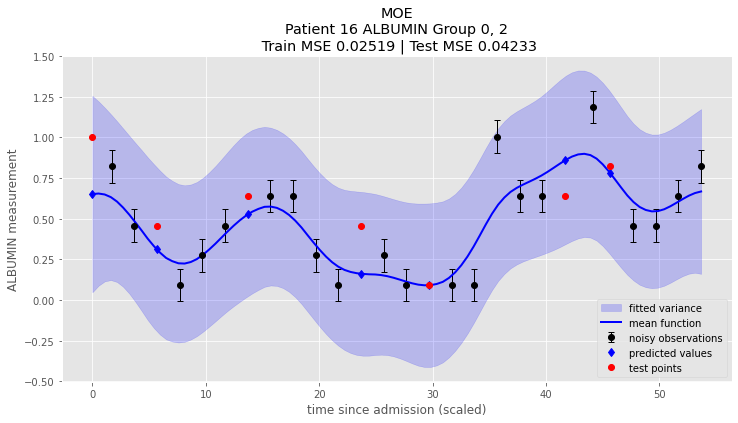

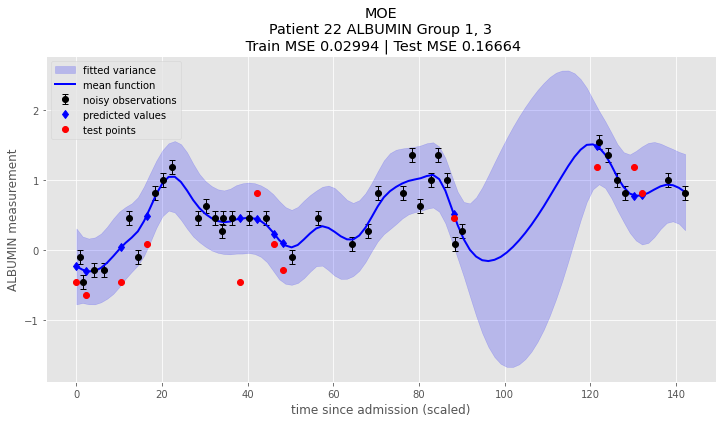

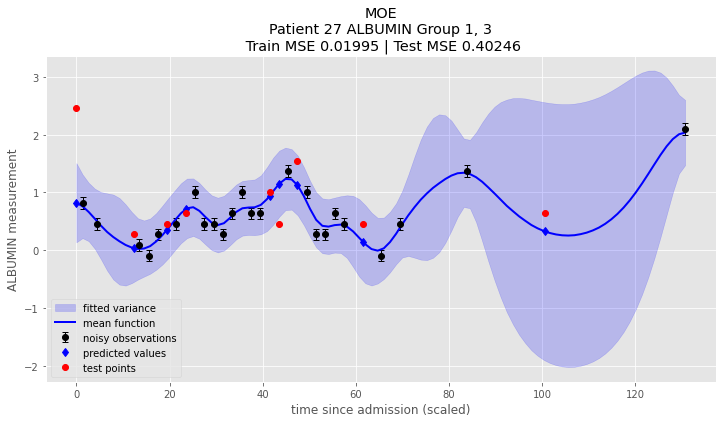

In [36]:
# Plot examples
for patient_idx in indices:
    pred_x(moe, patient_idx, 
           X, Y,
           cluster_assignments,
           X_test=X_test, Y_test=Y_test, model_name='MOE',
           feature=feature, n_test_points=10)

### Compare Metrics

In [37]:
r2_count_moe, = np.where(moe_train_r2 > gpr_train_r2)

print("Train R^2 is higher for MOE than GPR for %.3f%% of patients" %(len(r2_count_moe)/len(moe_ci) * 100))
print(" ")

r2_count_moe, = np.where(moe_test_r2 > gpr_test_r2)

print("Test R^2 is higher for MOE than GPR for %.3f%% of patients" %(len(r2_count_moe)/len(moe_ci) * 100))
print("")

ci_count_moe, = np.where(np.abs(moe_ci - 5) < np.abs(gpr_ci - 5))      
ci_same_moe, = np.where(np.abs(moe_ci - 5) == np.abs(gpr_ci - 5))

print("95%% CI is better for MOE than GPR for %.3f%% of patients" %(len(ci_count_moe)/len(moe_ci) * 100),
     " and the same for %.3f%% of patients" %(len(ci_same_moe)/len(moe_ci) * 100))

Train R^2 is higher for MOE than GPR for 73.171% of patients
 
Test R^2 is higher for MOE than GPR for 51.220% of patients

95% CI is better for MOE than GPR for 19.512% of patients  and the same for 68.293% of patients
